# **The seventh in-class-exercise (40 points in total, 10/20/2021)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chunghsinhsuan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.6 MB 8.4 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!pip install pyLDAvis==2.1.2
!pip install gensim==3.8.3
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/chunghsinhsuan/opt/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Import Dataset
df = pd.read_csv('O_result.csv')
df.head(100)

,Unnamed: 0,Text
0,0,Purchased this product advertised as fully unl...
1,1,"My phone re start over and over again, that's ..."
2,2,Bought refurbished Im assuming only open box a...
3,3,Great phones... I initially bought one for my ...
4,4,"No scratches or damage on the screen, or, for ..."
5,5,#NAME?
6,6,-battery capacity 100%
7,7,#NAME?
8,8,The lock screen is flickering and getting blu...
9,9,Honesty is greatly appreciated these days. The...


In [ ]:
import re
# Convert to list
data = df['Text'].tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', str(sent)) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", str(sent)) for sent in data]

pprint(data[:1])

['Purchased this product advertised as fully unlocked. Inserted my sim card '
 'and it did not work. Contacted my service provider and they checked my IMEI '
 'number and it reported that the phone was still locked by the original '
 'carrier. Phone came in good condition just couldnt use any service provider.']


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['purchased', 'this', 'product', 'advertised', 'as', 'fully', 'unlocked', 'inserted', 'my', 'sim', 'card', 'and', 'it', 'did', 'not', 'work', 'contacted', 'my', 'service', 'provider', 'and', 'they', 'checked', 'my', 'imei', 'number', 'and', 'it', 'reported', 'that', 'the', 'phone', 'was', 'still', 'locked', 'by', 'the', 'original', 'carrier', 'phone', 'came', 'in', 'good', 'condition', 'just', 'couldnt', 'use', 'any', 'service', 'provider']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['purchased', 'this', 'product', 'advertised', 'as', 'fully', 'unlocked', 'inserted', 'my', 'sim', 'card', 'and', 'it', 'did', 'not', 'work', 'contacted', 'my', 'service', 'provider', 'and', 'they', 'checked', 'my', 'imei', 'number', 'and', 'it', 'reported', 'that', 'the', 'phone', 'was', 'still', 'locked', 'by', 'the', 'original', 'carrier', 'phone', 'came', 'in', 'good', 'condition', 'just', 'couldnt', 'use', 'any', 'service', 'provider']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.blank("en")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['purchase', 'product', 'advertise', 'fully', 'unlocked', 'insert', 'sim', 'card', 'work', 'contact', 'service', 'provider', 'check', 'imei', 'number', 'report', 'phone', 'still', 'lock', 'original', 'carrier', 'phone', 'come', 'good', 'condition', 'service', 'provider']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1)]]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advertise', 1),
  ('card', 1),
  ('carrier', 1),
  ('check', 1),
  ('come', 1),
  ('condition', 1),
  ('contact', 1),
  ('fully', 1),
  ('good', 1),
  ('imei', 1),
  ('insert', 1),
  ('lock', 1),
  ('number', 1),
  ('original', 1),
  ('phone', 2),
  ('product', 1),
  ('provider', 2),
  ('purchase', 1),
  ('report', 1),
  ('service', 2),
  ('sim', 1),
  ('still', 1),
  ('unlocked', 1),
  ('work', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.003*"phone" + 0.003*"boost" + 0.003*"card" + 0.003*"back" + 0.003*"sim" + '
  '0.003*"exist" + 0.003*"order" + 0.003*"biggie" + 0.003*"pit" + '
  '0.003*"transfer"'),
 (1,
  '0.046*"phone" + 0.046*"charge" + 0.023*"get" + 0.023*"screen" + '
  '0.023*"battery" + 0.023*"cable" + 0.023*"accessory" + 0.023*"problem" + '
  '0.023*"arrive" + 0.012*"work"'),
 (2,
  '0.066*"phone" + 0.022*"recommend" + 0.022*"good" + 0.015*"box" + '
  '0.015*"seller" + 0.015*"item" + 0.015*"buy" + 0.015*"new" + 0.015*"brand" + '
  '0.015*"service"'),
 (3,
  '0.079*"phone" + 0.043*"come" + 0.029*"month" + 0.022*"battery" + '
  '0.022*"offer" + 0.022*"refurbish" + 0.022*"amazon" + 0.022*"capacity" + '
  '0.015*"apple" + 0.015*"scratch"'),
 (4,
  '0.024*"phone" + 0.023*"try" + 0.023*"flicker" + 0.023*"fine" + 0.023*"lock" '
  '+ 0.023*"get" + 0.023*"m" + 0.023*"seem" + 0.023*"else" + 0.023*"screen"'),
 (5,
  '0.119*"phone" + 0.045*"boost" + 0.030*"order" + 0.030*"exist" + 0.030*"sim" '
  '+ 0.030*"card"

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.407428908199536

Coherence Score:  0.4712347023975684


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.078733 -0.135582       1        1  18.757793
3     -0.121263 -0.112440       2        1  12.245457
2      0.000274 -0.118462       3        1  12.159418
19    -0.065271 -0.028051       4        1  10.133210
1     -0.009285  0.051695       5        1   7.071396
8     -0.148047  0.062417       6        1   6.136960
16    -0.061584 -0.125475       7        1   5.570743
5      0.093569  0.006779       8        1   5.050591
10     0.121656  0.029151       9        1   4.528457
9     -0.044323  0.117031      10        1   4.059791
13    -0.046511  0.014166      11        1   3.286422
11     0.113563 -0.020618      12        1   2.975964
4     -0.035610  0.065525      13        1   2.561263
18     0.001200  0.026246      14        1   1.832716
12     0.010599  0.015140      15        1   1.418154
14     0.019343  0.029513      16        1   1.002022
6      0.019486  0.039872      17        1   0.837518
7      0.023832  0.027194      18        1   0.126234
0      0.025240  0.027666      19        1   0.123943
15     0.024402  0.028233      20        1   0.121949, topic_info=          Term       Freq      Total Category  logprob  loglift
14       phone  55.000000  55.000000  Default  30.0000  30.0000
23        work  15.000000  15.000000  Default  29.0000  29.0000
4         come  12.000000  12.000000  Default  28.0000  28.0000
63         get  12.000000  12.000000  Default  27.0000  27.0000
42       great   7.000000   7.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
248        hot   0.002966   1.449037  Topic20  -5.9814   0.5177
274       kind   0.002966   1.411014  Topic20  -5.9814   0.5443
295  protector   0.002966   2.751197  Topic20  -5.9814  -0.1234
294    perfect   0.002966   1.224579  Topic20  -5.9814   0.6860
293      harsh   0.002966   1.224579  Topic20  -5.9814   0.6860

[977 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
326       5  0.479143        able
326       6  0.479143        able
182       2  0.712580  absolutely
327       5  0.947380   accessory
260       3  0.574395     account
...     ...       ...         ...
23       14  0.063518        work
55        7  0.778117       worth
205       5  0.530360        wrap
205      13  0.530360        wrap
389       2  0.712580       wrong

[665 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 4, 3, 20, 2, 9, 17, 6, 11, 10, 14, 12, 5, 19, 13, 15, 7, 8, 1, 16])

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-10-21 11:52:28--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  5.73MB/s    in 2.7s    

2021-10-21 11:52:31 (5.73 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Calo2Classify$2.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Calo2Classify$ReportOption.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Calo2Classify.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Classifier2Info.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Csv2Classify.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Csv2Vectors.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/SvmLight2Classify.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/SvmLight2Vectors.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Text2Classify.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Text2Vectors.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Vectors2Classify$1.class  
  inflating: mallet-2.0.8/class/cc/mallet/classify/tui/Vectors2Classify$2.class  
  inflating: mallet-2.0.8/class/cc/mallet/clas

  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/ConstrainedForwardBackwardConfidenceEstimator.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/ConstrainedViterbiTransducerCorrector.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/GammaAverageConfidenceEstimator.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/GammaProductConfidenceEstimator.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/InstanceWithConfidence.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/IsolatedSegmentTransducerCorrector.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/MaxEntConfidenceEstimator.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/MaxEntSequenceConfidenceEstimator.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/MinSegmentConfidenceEstimator.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/confidence/NBestViterbiConfidenceEstimator.class  
  inflating: mallet-2.

  inflating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/GELattice.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/GELatticeTask.class  
   creating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/pr/
  inflating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/pr/CachedDotTransitionIterator.class  
   creating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/pr/constraints/
  inflating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/pr/constraints/OneLabelL2IndPRConstraints$OneLabelL2IndPRConstraint.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/pr/constraints/OneLabelL2IndPRConstraints.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/pr/constraints/OneLabelL2PRConstraints$OneLabelPRConstraint.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/pr/constraints/OneLabelL2PRConstraints.class  
  inflating: mallet-2.0.8/class/cc/mallet/fst/semi_supervised/pr/constraints/PRConstraint.class  
  in

  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/RandomGraphs$FactorGenerator.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/RandomGraphs$UniformFactorGenerator.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/RandomGraphs.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/ResidualBP.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/Sampler.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/SamplingInferencer.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/TreeBP.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/TRP$1.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/TRP$AlmostRandomTreeFactory.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/TRP$ConvergenceTerminator.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/TRP$DefaultConvergenceTerminator.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/inference/TRP$Iteratio

  inflating: mallet-2.0.8/class/cc/mallet/grmm/util/MIntInt2ObjectMap.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/util/ModelReader.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/util/Models.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/util/ModelWriter.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/util/PipedIterator.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/util/RememberTokenizationPipe.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/util/SliceLabelsSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/util/THashMultiMap.class  
   creating: mallet-2.0.8/class/cc/mallet/optimize/
  inflating: mallet-2.0.8/class/cc/mallet/optimize/AGIS.class  
  inflating: mallet-2.0.8/class/cc/mallet/optimize/BackTrackLineSearch.class  
  inflating: mallet-2.0.8/class/cc/mallet/optimize/ConjugateGradient.class  
  inflating: mallet-2.0.8/class/cc/mallet/optimize/GradientAscent.class  
  inflating: mallet-2.0.8/class/cc/mallet/optimize/G

  inflating: mallet-2.0.8/class/cc/mallet/pipe/SerialPipes.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/SGML2TokenSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/SimpleTaggerSentence2StringTokenization.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/SimpleTaggerSentence2TokenSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/SimpleTokenizer.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/SourceLocation2TokenSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/StringAddNewLineDelimiter.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/StringList2FeatureSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/SvmLight2FeatureVectorAndLabel.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/Target2Double.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/Target2FeatureSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/Target2Integer.class  
  inflating: mallet-2.0.8/class/cc/mallet/pipe/Target

  inflating: mallet-2.0.8/class/cc/mallet/topics/WordEmbeddings.class  
  inflating: mallet-2.0.8/class/cc/mallet/topics/WorkerRunnable.class  
   creating: mallet-2.0.8/class/cc/mallet/types/
  inflating: mallet-2.0.8/class/cc/mallet/types/Alphabet.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/AlphabetCarrying.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/AlphabetFactory.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/ArrayListSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/ArraySequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/AugmentableFeatureVector.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/BiNormalSeparation$Factory.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/BiNormalSeparation.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/CachedMetric.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/ChainedInstanceIterator.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/ConstantMatrix.cl

  inflating: mallet-2.0.8/class/cc/mallet/types/Token.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/TokenSequence.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/Vector.class  
   creating: mallet-2.0.8/class/cc/mallet/util/
  inflating: mallet-2.0.8/class/cc/mallet/util/Addable.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/ArrayListUtils.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/ArrayUtils.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/BshInterpreter.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/BulkLoader.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/CharSequenceLexer.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/CollectionUtils$1Accumulator.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/CollectionUtils$Fn.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/CollectionUtils.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/ColorUtils.class  
  inflating: mallet-2.0.8/class/cc/mallet/util/Command

  inflating: mallet-2.0.8/sample-data/web/en/hawes.txt  
  inflating: mallet-2.0.8/sample-data/web/en/hill.txt  
  inflating: mallet-2.0.8/sample-data/web/en/shiloh.txt  
  inflating: mallet-2.0.8/sample-data/web/en/sunderland_echo.txt  
  inflating: mallet-2.0.8/sample-data/web/en/thespis.txt  
  inflating: mallet-2.0.8/sample-data/web/en/thylacine.txt  
  inflating: mallet-2.0.8/sample-data/web/en/uranus.txt  
  inflating: mallet-2.0.8/sample-data/web/en/yard.txt  
  inflating: mallet-2.0.8/sample-data/web/en/zinta.txt  
   creating: mallet-2.0.8/src/
   creating: mallet-2.0.8/src/cc/
   creating: mallet-2.0.8/src/cc/mallet/
   creating: mallet-2.0.8/src/cc/mallet/classify/
  inflating: mallet-2.0.8/src/cc/mallet/classify/AdaBoost.java  
  inflating: mallet-2.0.8/src/cc/mallet/classify/AdaBoostM2.java  
  inflating: mallet-2.0.8/src/cc/mallet/classify/AdaBoostM2Trainer.java  
  inflating: mallet-2.0.8/src/cc/mallet/classify/AdaBoostTrainer.java  
  inflating: mallet-2.0.8/src/cc/mall

   creating: mallet-2.0.8/src/cc/mallet/cluster/iterator/
  inflating: mallet-2.0.8/src/cc/mallet/cluster/iterator/AllPairsIterator.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/iterator/ClusterSampleIterator.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/iterator/NeighborIterator.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/iterator/NodeClusterSampleIterator.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/iterator/PairSampleIterator.java  
   creating: mallet-2.0.8/src/cc/mallet/cluster/iterator/tests/
  inflating: mallet-2.0.8/src/cc/mallet/cluster/iterator/tests/TestIterators.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/KBestClusterer.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/KMeans.java  
   creating: mallet-2.0.8/src/cc/mallet/cluster/neighbor_evaluator/
  inflating: mallet-2.0.8/src/cc/mallet/cluster/neighbor_evaluator/AgglomerativeNeighbor.java  
  inflating: mallet-2.0.8/src/cc/mallet/cluster/neighbor_evaluator/Classifyin

  inflating: mallet-2.0.8/src/cc/mallet/fst/CRFTrainerByStochasticGradient.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/CRFTrainerByThreadedLabelLikelihood.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/CRFTrainerByValueGradients.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/CRFWriter.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/FeatureTransducer.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/HMM.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/HMMTrainerByLikelihood.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/InstanceAccuracyEvaluator.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/LabelDistributionEvaluator.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/MaxLattice.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/MaxLatticeDefault.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/MaxLatticeFactory.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/MEMM.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/MEMMTrainer.java  
  inflating: mallet-

  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/DefaultAcrfTrainer.java  
   creating: mallet-2.0.8/src/cc/mallet/grmm/learning/extract/
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/extract/ACRFExtractor.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/extract/ACRFExtractorTrainer.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/extract/AcrfExtractorTui.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/GenericAcrfData2TokenSequence.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/GenericAcrfTui.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/MultiSegmentationEvaluatorACRF.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/PiecewiseACRFTrainer.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/PseudolikelihoodACRFTrainer.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/PwplACRFTrainer.java  
   creating: mallet-2.0.8/src/cc/mallet/grmm/learning/templates/
  inflating: mallet-2.0.8/

  inflating: mallet-2.0.8/src/cc/mallet/pipe/Csv2FeatureVector.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/Directory2FileIterator.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FeatureCountPipe.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FeatureDocFreqPipe.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FeatureSequence2AugmentableFeatureVector.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FeatureSequence2FeatureVector.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FeatureSequenceConvolution.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FeatureValueString2FeatureVector.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FeatureVectorConjunctions.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FeatureVectorSequence2FeatureVectors.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/Filename2CharSequence.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FilterEmptyFeatureVectors.java  
  inflating: mallet-2.0.8/src/cc/mallet/pipe/FixedVocabTo

  inflating: mallet-2.0.8/src/cc/mallet/topics/MarginalProbEstimator.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/MultinomialHMM.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/NPTopicModel.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/PAM4L.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/ParallelTopicModel.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/PolylingualTopicModel.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/RTopicModel.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/SimpleLDA.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/TopicalNGrams.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/TopicAssignment.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/TopicInferencer.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/TopicModelDiagnostics.java  
  inflating: mallet-2.0.8/src/cc/mallet/topics/TopicReports.java  
   creating: mallet-2.0.8/src/cc/mallet/topics/tui/
  inflating: mallet-2.0.8/src/cc/mallet/topics

  inflating: mallet-2.0.8/src/cc/mallet/util/MalletLogger.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/MalletProgressMessageLogger.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/Maths.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/MVNormal.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/package.html  
  inflating: mallet-2.0.8/src/cc/mallet/util/PlainLogFormatter.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/PrintUtilities.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/ProgressMessageLogFormatter.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/ProgressMessageLogRecord.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/PropertyList.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/Randoms.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/RegexFileFilter.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/Replacement.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/Replacer.java  
   creating: mallet-2.0.8/src/cc/mallet/util/resources/
  inflat

In [ ]:
mallet_path = "mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('life', 0.1388888888888889),
   ('contact', 0.1111111111111111),
   ('unlocked', 0.08333333333333333),
   ('happy', 0.08333333333333333),
   ('support', 0.05555555555555555),
   ('transfer', 0.027777777777777776),
   ('clean', 0.027777777777777776),
   ('play', 0.027777777777777776),
   ('attention', 0.027777777777777776),
   ('glitch', 0.027777777777777776)]),
 (18,
  [('buy', 0.28888888888888886),
   ('boost', 0.06666666666666667),
   ('offer', 0.06666666666666667),
   ('scratch', 0.06666666666666667),
   ('phone', 0.044444444444444446),
   ('decide', 0.044444444444444446),
   ('bad', 0.022222222222222223),
   ('order', 0.022222222222222223),
   ('refund', 0.022222222222222223),
   ('make', 0.022222222222222223)]),
 (3,
  [('month', 0.23529411764705882),
   ('amazon', 0.20588235294117646),
   ('crack', 0.058823529411764705),
   ('call', 0.029411764705882353),
   ('promise', 0.029411764705882353),
   ('save', 0.029411764705882353),
   ('device', 0.029411764705882353),
   ('cr

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=after_lemmatization, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(6,
  [('renew', 0.15384615384615385),
   ('review', 0.15384615384615385),
   ('verizon', 0.1282051282051282),
   ('give', 0.10256410256410256),
   ('couple', 0.05128205128205128),
   ('matter', 0.02564102564102564),
   ('today', 0.02564102564102564),
   ('io', 0.02564102564102564),
   ('skip', 0.02564102564102564),
   ('suppose', 0.02564102564102564)]),
 (15,
  [('phone', 0.2619047619047619),
   ('arrive', 0.09523809523809523),
   ('warranty', 0.09523809523809523),
   ('refurbish', 0.07142857142857142),
   ('capacity', 0.047619047619047616),
   ('card', 0.047619047619047616),
   ('couple', 0.047619047619047616),
   ('great', 0.023809523809523808),
   ('apparently', 0.023809523809523808),
   ('small', 0.023809523809523808)]),
 (8,
  [('phone', 0.28),
   ('great', 0.18),
   ('switch', 0.06),
   ('power', 0.02),
   ('prepaid', 0.02),
   ('thinner', 0.02),
   ('package', 0.02),
   ('complaint', 0.02),
   ('annoyance', 0.02),
   ('kind', 0.02)]),
 (4,
  [('scratch', 0.10810810810810811),


NameError: name 'after_lemmatization' is not defined

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

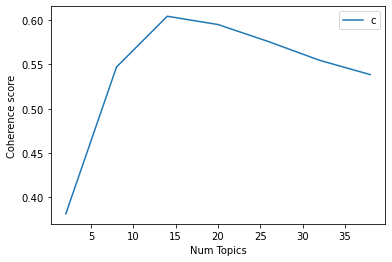

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3815
Num Topics = 8  has Coherence Value of 0.5471
Num Topics = 14  has Coherence Value of 0.6043
Num Topics = 20  has Coherence Value of 0.595
Num Topics = 26  has Coherence Value of 0.5757
Num Topics = 32  has Coherence Value of 0.5547
Num Topics = 38  has Coherence Value of 0.5385


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.194*"review" + 0.097*"expect" + 0.065*"deliver" + 0.065*"refund" + '
  '0.065*"put" + 0.065*"return" + 0.032*"circle" + 0.032*"lot" + '
  '0.032*"absolutely" + 0.032*"people"'),
 (1,
  '0.174*"month" + 0.152*"refurbish" + 0.152*"amazon" + 0.087*"pay" + '
  '0.065*"offer" + 0.043*"long" + 0.043*"protection" + 0.022*"issue" + '
  '0.022*"direct" + 0.022*"matter"'),
 (2,
  '0.632*"phone" + 0.079*"fine" + 0.053*"cable" + 0.026*"glitch" + '
  '0.026*"dilike" + 0.026*"nice" + 0.026*"small" + 0.026*"family" + '
  '0.026*"biggie" + 0.026*"store"'),
 (3,
  '0.255*"phone" + 0.098*"purchase" + 0.078*"account" + 0.059*"capacity" + '
  '0.039*"activate" + 0.039*"sprint" + 0.039*"item" + 0.039*"good" + '
  '0.039*"package" + 0.020*"saving"'),
 (4,
  '0.292*"service" + 0.125*"issue" + 0.125*"send" + 0.042*"nice" + '
  '0.042*"partly" + 0.042*"instal" + 0.042*"debit" + 0.042*"literally" + '
  '0.042*"notife" + 0.042*"unusable"'),
 (5,
  '0.154*"card" + 0.115*"original" + 0.115*"price" + 0.07

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.1074,"work, contact, provider, original, protector, ...",Purchased this product advertised as fully unl...
1,1,14.0,0.0628,"iphone, couple, life, decide, exist, store, no...","My phone re start over and over again, thats s..."
2,2,5.0,0.0612,"card, original, price, receive, sim, end, daug...",Bought refurbished Im assuming only open box a...
3,3,5.0,0.0692,"card, original, price, receive, sim, end, daug...",Great phones... I initially bought one for my ...
4,4,1.0,0.0792,"month, refurbish, amazon, pay, offer, long, pr...","No scratches or damage on the screen, or, for ..."
5,5,0.0,0.0500,"review, expect, deliver, refund, put, return, ...",#NAME?
6,6,3.0,0.0652,"phone, purchase, account, capacity, activate, ...",-battery capacity 100%
7,7,0.0,0.0500,"review, expect, deliver, refund, put, return, ...",#NAME?
8,8,19.0,0.0653,"renew, unlocked, boost, start, sim, support, b...",The lock screen is flickering and getting blu...
9,9,0.0,0.1186,"review, expect, deliver, refund, put, return, ...",Honesty is greatly appreciated these days. The...


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,17.0,"work, contact, provider, original, protector, ...",7.0,0.1373
1.0,14.0,"iphone, couple, life, decide, exist, store, no...",3.0,0.0588
2.0,5.0,"card, original, price, receive, sim, end, daug...",1.0,0.0196
3.0,5.0,"card, original, price, receive, sim, end, daug...",6.0,0.1176
4.0,1.0,"month, refurbish, amazon, pay, offer, long, pr...",NaN,NaN
5.0,0.0,"review, expect, deliver, refund, put, return, ...",2.0,0.0392
6.0,3.0,"phone, purchase, account, capacity, activate, ...",3.0,0.0588
7.0,0.0,"review, expect, deliver, refund, put, return, ...",3.0,0.0588
8.0,19.0,"renew, unlocked, boost, start, sim, support, b...",1.0,0.0196
9.0,0.0,"review, expect, deliver, refund, put, return, ...",2.0,0.0392


### (2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


In [ ]:
def prepare_corpus(doc_clean):    
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):    
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [ ]:
number_of_topics=7
words=10
document_list,titles=load_data("","review.txt")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 51
[(0, '0.784*"phone" + 0.145*"work" + 0.134*"batteri" + 0.114*"get" + 0.113*"amazon" + 0.099*"servic" + 0.095*"iphon" + 0.095*"month" + 0.094*"would" + 0.091*"day"'), (1, '0.276*"month" + 0.201*"refurbish" + 0.194*"35" + 0.194*"offer" + 0.192*"thank" + -0.183*"day" + -0.182*"iphon" + -0.174*"batteri" + -0.166*"look" + -0.161*"far"'), (2, '-0.304*"amazon" + 0.252*"phone" + -0.243*"month" + -0.174*"day" + -0.160*"refurbish" + -0.153*"thank" + -0.151*"offer" + -0.151*"35" + -0.141*"iphon" + -0.134*"batteri"'), (3, '0.290*"charg" + 0.220*"batteri" + -0.186*"iphon" + -0.171*"order" + 0.160*"appl" + -0.159*"boost" + 0.155*"problem" + 0.148*"would" + 0.142*"well" + -0.139*"back"'), (4, '0.282*"appl" + 0.241*"charger" + -0.190*"charg" + 0.186*"origin" + 0.183*"came" + 0.181*"box" + -0.168*"anoth" + 0.168*"use" + 0.154*"come" + 0.145*"good"'), (5, '-0.202*"purchas" + -0.194*"account" + 0.182*"charg" + -0.182*"mani" + -0.180*"verizon" + -0.178*"never" + -0.172*"revie

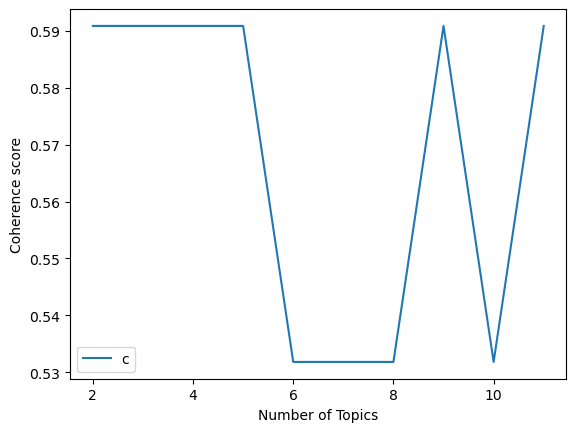

In [ ]:
start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

In [ ]:
dictionary,doc_term_matrix= prepare_corpus(clean_text)
model_list_lsa,coherence_values_lsa = compute_coherence_values(dictionary,doc_term_matrix,clean_text,40,2,6)

In [ ]:
x = range(start, stop, step)
for m, cv in zip(x, coherence_values_lsa):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5909
Num Topics = 3  has Coherence Value of 0.5909
Num Topics = 4  has Coherence Value of 0.5909
Num Topics = 5  has Coherence Value of 0.5318
Num Topics = 6  has Coherence Value of 0.5318
Num Topics = 7  has Coherence Value of 0.5318
Num Topics = 8  has Coherence Value of 0.5318


## (3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

I infer LDA is better than LSA because the coherence score of LDA is higher than it of LSA, and LDA gives better and more understandable results with more topics than LSA.
LSA algorithm is simple, easy to understand, and implement. It is faster compared to other available algorithms because it involves document term matrix decomposition only. 
However, LSA is unable to capture the multiple meanings of words. It has certain topics repeating. It is not easier to implement compared to LDA( latent Dirichlet allocation). 
LSA offers lower accuracy than LDA.